In [1]:
#%matplotlib widget
from typing import List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io, requests
from astropy import units as u


# type aliases
ArrayLike = Union[np.ndarray, List[float], List[int], float, int]

c = 2.99792458e8 * (u.m / u.s)

In [2]:
url_tau="https://github.com/ishiishun/lst/raw/master/data/tau.csv"
url_Tsky="https://github.com/ishiishun/lst/raw/master/data/Tsky.csv"
s_tau=requests.get(url_tau).content
s_Tsky=requests.get(url_Tsky).content

In [3]:
tau_df_zenith = pd.read_csv(io.StringIO(s_tau.decode('utf-8')),
        skiprows=4,
        delim_whitespace=True,
        header=0,
        index_col=0
    )

Tsky_df_zenith = pd.read_csv(io.StringIO(s_Tsky.decode('utf-8')),
        skiprows=4,
        delim_whitespace=True,
        header=0,
        index_col=0
    )


In [4]:
Bands = {
    '3': {"f_min": 84.* (u.GHz), "f_max":116 * (u.GHz), "pwv":5.186, "Trx":40. * (u.K)},  #f_min (GHz), f_max(GHz), pwv(mm), Trx(K) from ALMA OT 
    '4': {"f_min":116.1 * (u.GHz), "f_max":163 * (u.GHz), "pwv":2.748, "Trx": 42.* (u.K)}, 
    '5': {"f_min":163.1 * (u.GHz), "f_max":211 * (u.GHz), "pwv":1.796, "Trx": 50.* (u.K)}, 
    '6': {"f_min":211.1 * (u.GHz), "f_max":275 * (u.GHz), "pwv":1.796, "Trx": 50.* (u.K)}, 
    '7': {"f_min":275.1 * (u.GHz), "f_max":373 * (u.GHz), "pwv":0.913, "Trx": 72.* (u.K)}, 
    '8': {"f_min":373.1 * (u.GHz), "f_max":500 * (u.GHz), "pwv":0.658, "Trx":135.* (u.K)}
    }

In [5]:
def tau_func(pwv, EL):
    tau0 = tau_df_zenith[str(pwv)]
    tau = tau0/ np.sin(EL * np.pi / 180.0)
    return tau

def Tsky_func(pwv, EL):
    tau0 = tau_df_zenith[str(pwv)]
    Tsky0 = Tsky_df_zenith[str(pwv)]
    tau = tau0/ np.sin(EL * np.pi / 180.0)
    Tsky = Tsky0 * (1. - np.exp(-tau))/(1 - np.exp(-tau0))
    return Tsky* (u.K)

In [6]:
def get_Tsys(band, EL = 60., eta_eff = 0.95, Tamb = 270.* (u.K)):
    f_min = Bands[band]["f_min"].value
    f_max = Bands[band]["f_max"].value
    pwv = Bands[band]["pwv"]
    Trx = Bands[band]["Trx"]
    tau = tau_func(Bands[band]["pwv"], EL)
    Tsky = Tsky_func(Bands[band]["pwv"], EL).values
    eta_atm = np.exp(-tau)
    Tsys = 1./(eta_eff*eta_atm)*(Trx + eta_eff*Tsky + (1.-eta_eff)*Tamb)
#    return Tsys[f_min:f_max], tau[f_min:f_max], Tsky[f_min:f_max]
    return Tsys, tau, Tsky

In [7]:
def get_Tsys_all(band, EL = 60., eta_eff = 0.95, Tamb = 270.* (u.K) ):
    pwvs = [0.472, 0.658, 0.913, 1.262, 1.796, 2.748, 5.186]
    df_Tsys = pd.DataFrame()
    for pwv in pwvs:
        f_min = Bands[band]["f_min"].value
        f_max = Bands[band]["f_max"].value
        Trx = Bands[band]["Trx"]
        tau = tau_func(str(pwv), EL)
        Tsky = Tsky_func(str(pwv), EL).values
        eta_atm = np.exp(-tau)
        Tsys = 1./(eta_eff*eta_atm)*(Trx + eta_eff*Tsky + (1.-eta_eff)*Tamb)
        df_Tsys[str(pwv)]= Tsys[f_min:f_max]
    df_ratio = pd.DataFrame()
    for column in df_Tsys.columns:
        ratio = df_Tsys[column]/df_Tsys["0.472"].values
        df_ratio[column]= ratio
    return df_Tsys, df_ratio

In [8]:
#band 3
band = "3"
EL = 60.
Tsys, tau, Tsky = get_Tsys(band, EL)
df_Tsys3, df_ratio = get_Tsys_all(band, EL)

In [9]:
df_Tsyss = pd.DataFrame()
df_ratios = pd.DataFrame()
EL = 60.
for band in ['3','4','5','6','7','8']:
    df_Tsys, df_ratio = get_Tsys_all(band, EL)
    df_Tsyss = df_Tsyss.append(df_Tsys)
    df_ratios = df_ratios.append(df_ratio)
    

In [10]:
df_Tsyss

,0.472,0.658,0.913,1.262,1.796,2.748,5.186
F,,,,,,,
84.0,66.583515,66.942915,67.408135,68.093966,69.138962,70.979674,75.659353
84.1,66.551693,66.912239,67.377426,68.064374,69.111650,70.873679,75.642420
84.2,66.519871,66.881563,67.347898,68.035965,69.084337,70.851018,75.626697
84.3,66.489228,66.850887,67.318369,68.007557,69.057024,70.827166,75.610974
84.4,66.458585,66.820210,67.288841,67.979149,68.953263,70.804505,75.595251
...,...,...,...,...,...,...,...
499.6,555.278311,768.625533,1156.974887,1937.828127,4049.150313,14069.210218,310865.349025
499.7,556.926755,770.965833,1161.809680,1947.990776,4079.069487,14219.218661,317039.279467
499.8,558.000265,773.358319,1166.715121,1958.261855,4109.274572,14387.342632,323708.375549


In [11]:
df_ratios

,0.472,0.658,0.913,1.262,1.796,2.748,5.186
F,,,,,,,
84.0,1.0,1.005398,1.012385,1.022685,1.038380,1.066025,1.136308
84.1,1.0,1.005418,1.012407,1.022729,1.038466,1.064942,1.136596
84.2,1.0,1.005437,1.012448,1.022792,1.038552,1.065111,1.136904
84.3,1.0,1.005439,1.012470,1.022836,1.038620,1.065243,1.137191
84.4,1.0,1.005441,1.012493,1.022880,1.037537,1.065393,1.137479
...,...,...,...,...,...,...,...
499.6,1.0,1.384217,2.083595,3.489832,7.292110,25.337223,559.837009
499.7,1.0,1.384322,2.086109,3.497750,7.324248,25.531578,569.265665
499.8,1.0,1.385946,2.090886,3.509428,7.364288,25.783756,580.122261


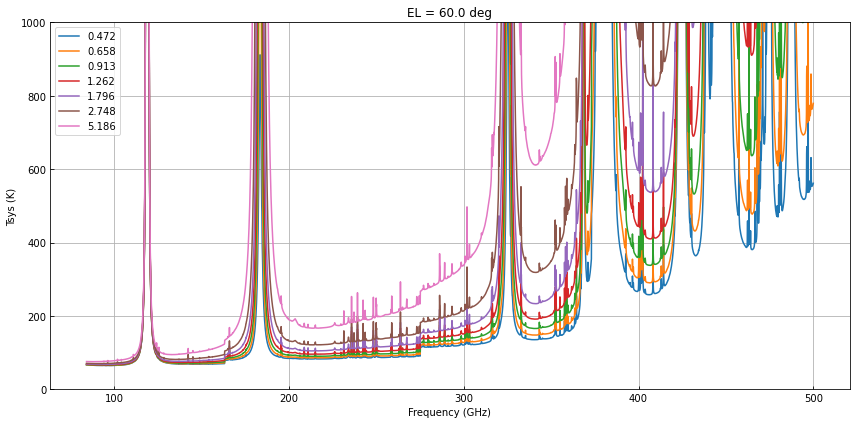

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_Tsyss.plot(ax = ax)

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Tsys (K)")
ax.set_ylim(0, np.min([df_Tsyss["5.186"].max(), 1000.]))
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(EL),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

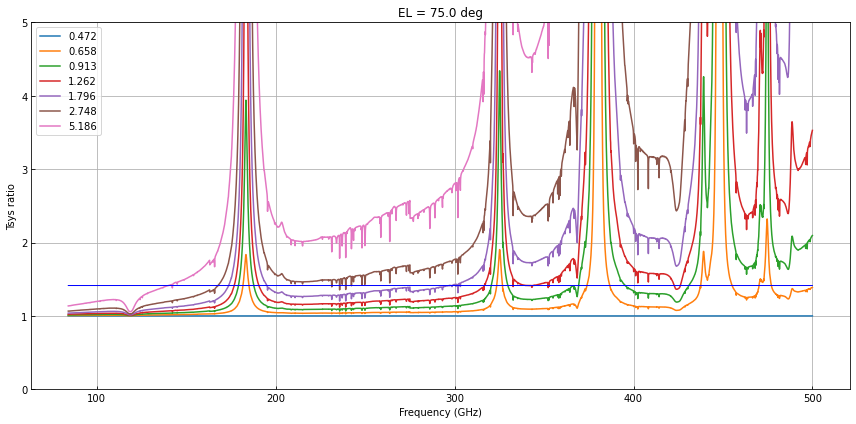

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

df_ratios.plot(ax = ax)
x = df_ratios.index
ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"Tsys ratio")
ax.set_ylim(0, 5)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(75.),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

In [14]:
df = df_ratios<np.sqrt(2)
vallist = []
vallist2 = []
vallist3 = []
for idx in df.index:
    if pd.isna(df_ratios[idx:idx]["0.472"].values) == True:
        octile = 1
        pwv = "0.472"
    elif (idx > 211. and idx < 275.): # fix the PWV for band 6 to 1.796 mm
        octile = 5
        pwv = "1.796"
    else:
        octile = np.where(df[idx:idx] == True)[1][-1]+1
        pwv = df.columns[np.where(df[idx:idx] == True)[1][-1]]
    vallist.append(octile)
    vallist2.append(pwv)
    vallist3.append(df_Tsyss[pwv][idx:idx].values[0])
df_Tsyss["octile"] = vallist
df_Tsyss["pwv"] = vallist2
df_Tsyss["Tsys"] = vallist3

In [15]:
df_Tsyss

,0.472,0.658,0.913,1.262,1.796,2.748,5.186,octile,pwv,Tsys
F,,,,,,,,,,
84.0,66.583515,66.942915,67.408135,68.093966,69.138962,70.979674,75.659353,7,5.186,75.659353
84.1,66.551693,66.912239,67.377426,68.064374,69.111650,70.873679,75.642420,7,5.186,75.642420
84.2,66.519871,66.881563,67.347898,68.035965,69.084337,70.851018,75.626697,7,5.186,75.626697
84.3,66.489228,66.850887,67.318369,68.007557,69.057024,70.827166,75.610974,7,5.186,75.610974
84.4,66.458585,66.820210,67.288841,67.979149,68.953263,70.804505,75.595251,7,5.186,75.595251
...,...,...,...,...,...,...,...,...,...,...
499.6,555.278311,768.625533,1156.974887,1937.828127,4049.150313,14069.210218,310865.349025,2,0.658,768.625533
499.7,556.926755,770.965833,1161.809680,1947.990776,4079.069487,14219.218661,317039.279467,2,0.658,770.965833
499.8,558.000265,773.358319,1166.715121,1958.261855,4109.274572,14387.342632,323708.375549,2,0.658,773.358319


In [16]:
df_Tsyss["Tsys"].values

array([ 75.65935323,  75.64242047,  75.6266972 , ..., 773.35831934,
       776.68827371, 779.22127104])

In [17]:
def PlotOcgile():
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    df_Tsyss['octile'].plot(ax = ax)
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel(r"Octile")
    ax.set_ylim(0, 8)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg".format(EL),
        fontsize=12,
    )
    ax.legend()
    fig.tight_layout()
    return

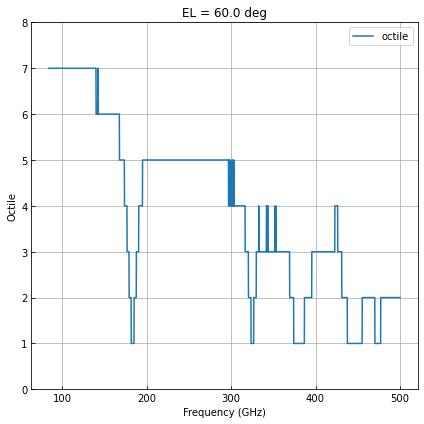

In [18]:
PlotOcgile()

In [19]:
def PlotTsys():
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    df_Tsyss['Tsys'][84.0:500].plot(ax = ax)
    #x = df_ratio.index
    #ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel(r"Tsys")
    #ax.set_yscale("log")
    #ax.set_xlim(Bands[band]["f_min"], Bands[band]["f_max"])
    ax.set_ylim(0, np.min([df_Tsyss["Tsys"].max(), 1000.]))
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg".format(EL),
        fontsize=12,
    )
    ax.legend()


    fig.tight_layout()
    return

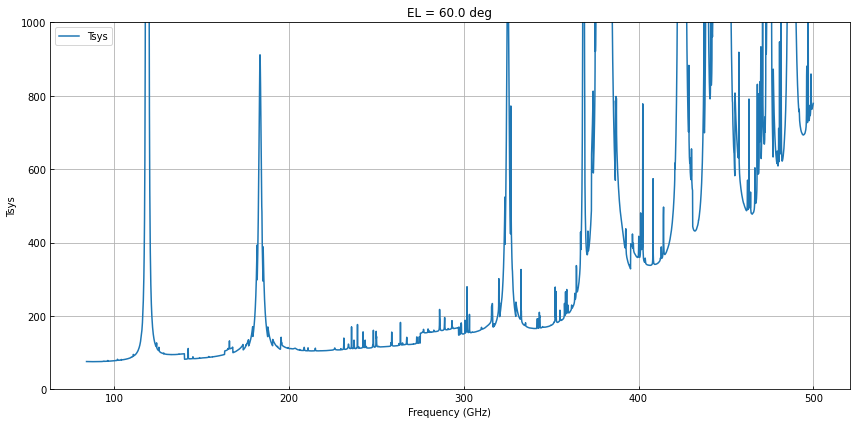

In [20]:
PlotTsys()

In [21]:
def LST_HPBW(F: ArrayLike, D = 50*(u.m)) -> ArrayLike:
    wavelength =  c/F
    return 1.21 * wavelength/D
    

In [22]:
def PlotHPBW():
    """Plot half power beam width of DESHIMA 2.0 on ASTE.

    Returns
    -------
    html
        HTML object for download link (to be used in Jupyter notebook).

    """
    F = np.arange(84., 500.1, 0.1)*1e9 * (u.Hz)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(
        F / 1e9,
        LST_HPBW(F) * 180 * 60 * 60 / np.pi,
        linewidth=1,
        color="b",
        alpha=1,
        label="HPBW",
    )

    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("HPBW (arcsec)")
    ax.set_yscale("linear")
    ax.set_xlim(84, 500)
    ax.set_ylim(0, 20)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()

    # Create download link
    df_download = pd.DataFrame(data=F, columns=["F"])
    df_download["HPBW"] = LST_HPBW(F) * 180 * 60 * 60 / np.pi

    return



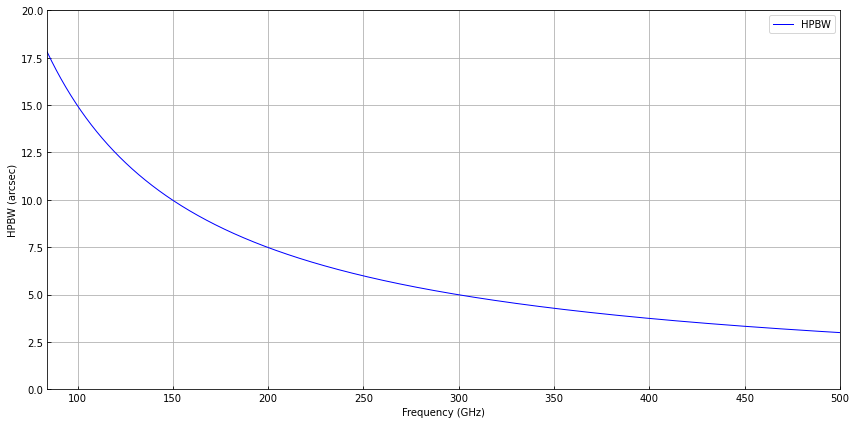

In [23]:
PlotHPBW()

In [24]:
def get_dTa(F,                      # frequency, in Hz
            HPBW,                   # HPBW, in arcsec.          
            df_Tsyss,               # Tsys dataframe
            sample_length = 1./5,   # length of the scan per a sample of integration, in HPBW 
            cell_size = 1./9,       # cell size, in HPBW
            sep_scan = 1./3,        # separation of raster scans, in HPBW
            t_dump = 0.1,           # in sec.
            t_sub_on = 20,          # in sec.
            N_scan = 2,             # number of the raster scans per an OFF scan
            d_OFF = 60.,            # separation between ON and OFF, in arcmin., assuming a 1-deg separation
            dV = 0.3,               # velocity resolution in km/s  
            N_beam = 100.,          # number of beams
            n_pol = 2.,             # number of pol
            dTa_des = 0.3           # desired sensitivity in K
           ):
    F = F/1e9
    v = HPBW*sample_length/t_dump   # scan velociy 
    cell = HPBW*cell_size           # cell size (Brogan & Hunter 2014)
    sep_scan = HPBW*sep_scan  
    w_x = v*t_sub_on
    w_y = w_x
    area = w_x*w_y/3600./3600.      # in deg^2
    N_row = np.ceil(w_y/sep_scan)
    t_os = t_sub_on*N_row
    t_tran = 7.
    t_app = 6.
    t_tran_OFF = np.ceil(4.4*d_OFF**(0.26)) 
    t_OH = 2*t_tran_OFF/N_scan + t_app + t_tran*(N_scan-1)/N_scan
    f_cal = 16./15. # R-Sky every 15 min.
    eta = 10.2
    t_sub_off = np.sqrt((t_sub_on + t_OH)* eta*cell*t_sub_on/w_x)*np.sqrt(N_scan)
    t_cell_on = eta*t_sub_on*cell*cell/(w_x*sep_scan)*N_beam*n_pol
    t_cell_off = t_sub_off*cell/sep_scan*N_beam*n_pol
    dfreq = F*dV/(c/1.e3)*1.e9
    dTa = df_Tsyss['Tsys'][F[0]:F[-1]].values*np.sqrt(1/t_cell_on + 1/t_cell_off)/np.sqrt(dfreq)
    Tsys_factor_nro = 1.1*np.exp(-0.18*(1/np.sin(70./180*np.pi)-1/np.sin(EL/180*np.pi)))
    dTa_nro = Tsys_factor_nro*dTa/0.88 #devided by the efficiency of the spectrometer
    t_total = N_row*(t_sub_on + t_OH + t_sub_off/N_scan)*f_cal
    df_dTa = pd.DataFrame(index = F)
    df_dTa.index.name = "F"
    df_dTa["Tsys"] = df_Tsyss['Tsys'][F[0]:F[-1]].values
    df_dTa["HPBW"] = HPBW
    df_dTa["dTa"] = dTa
    df_dTa["t_total"] = t_total/60./60.
    df_dTa["map_size"] = w_x
    df_dTa["area"] = area
    t_total_for_dTa_des_1deg2 = (t_total/60./60.)*np.power(dTa/dTa_des, 2.)/area
    df_dTa["t_total_dTa_des_1deg2"] = t_total_for_dTa_des_1deg2
    return df_dTa, N_beam, t_dump, dTa_des

In [25]:
F = df_Tsyss.index*1.e9
HPBW = LST_HPBW(F, D=50.) * 180 * 60 * 60 / np.pi

df_dTa, N_beam, t_dump, dTa_des = get_dTa(F, HPBW, df_Tsyss) 

In [26]:
df_dTa

,Tsys,HPBW,dTa,t_total,map_size,area,t_total_dTa_des_1deg2
F,,,,,,,
84.0,75.659353,17.814840,0.044157,1.648114,712.593583,0.039181,0.911300
84.1,75.642420,17.793657,0.044121,1.648114,711.746266,0.039088,0.911977
84.2,75.626697,17.772524,0.044085,1.634493,710.900962,0.038995,0.905139
84.3,75.610974,17.751442,0.044050,1.634493,710.057663,0.038903,0.905837
84.4,75.595251,17.730409,0.044015,1.648114,709.216363,0.038811,0.914089
...,...,...,...,...,...,...,...
499.6,768.625533,2.995289,0.183941,1.634493,119.811571,0.001108,554.759597
499.7,770.965833,2.994690,0.184483,1.648114,119.787595,0.001107,562.906828
499.8,773.358319,2.994091,0.185037,1.634493,119.763627,0.001107,561.837283


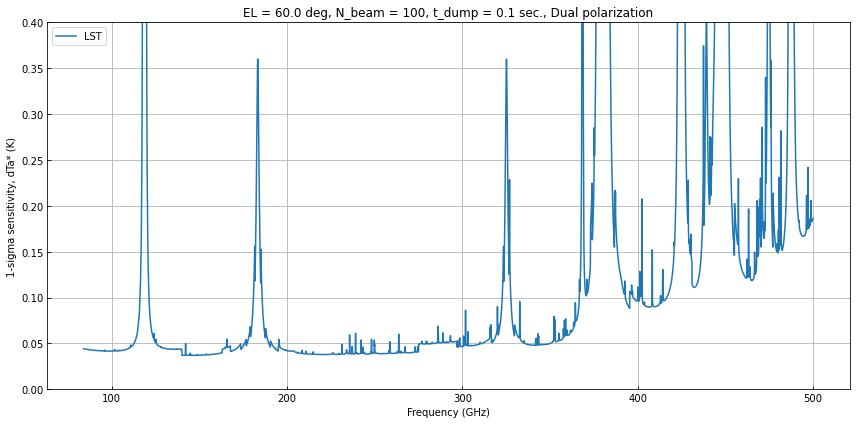

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(df_dTa.index, df_dTa["dTa"], label = "LST")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("1-sigma sensitivity, dTa* (K)")
ax.set_ylim(0, 0.4)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg, N_beam = {}, t_dump = {} sec., Dual polarization".format(EL, int(N_beam), t_dump),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

In [28]:
# examples for specific emission lines

print("*Survey Speed: 100 beams, 1 deg^2, dTa* = 0.3 K, dV = 0.3 km/s, Dual polarization\n")
# time for CO(3-2) at 345.8 GHz
f = 345.796
t_obs = df_dTa["t_total_dTa_des_1deg2"][np.round(f, decimals=1)]
print("- CO(3-2) at {0:} GHz: t_obs = {1:.2f} hr".format(f, t_obs))

# time for 13CO(1-0) at 110.2 GHz
f = 110.201
t_obs = df_dTa["t_total_dTa_des_1deg2"][np.round(f, decimals=1)]
print("- 13CO(1-0) at {0:} GHz: t_obs = {1:.2f} hr".format(f, t_obs))


*Survey Speed: 100 beams, 1 deg^2, dTa* = 0.3 K, dV = 0.3 km/s, Dual polarization

- CO(3-2) at 345.796 GHz: t_obs = 18.86 hr
- 13CO(1-0) at 110.201 GHz: t_obs = 1.63 hr


In [29]:
lines = {
    'CO(3-2)': 345.796, 
    '13CO(3-2)': 330.588,
    'C18O(3-2)': 329.331,
    'CO(2-1)': 230.538,
    '13CO(2-1)': 220.399,
    'C18O(2-1)': 219.56,
    'CO(1-0)': 115.271,
    '13CO(1-0)': 110.201,
    'C18O(1-0)': 109.782,
    'CS(2-1)': 97.980,
    'CS(3-2)': 146.969,
    'CS(4-3)': 195.954,
    'CS(5-4)': 244.953,
    'CS(6-5)': 293.912,
    'CS(7-6)': 342.882,
    'HCN(1-0)': 88.631,
    'HCN(2-1)': 177.261,
    'HCN(3-2)': 265.886,
    'HCN(4-3)': 354.505,
#    'CI(1-0)': 492.160,
    }

lines2 = {
    'CO(3-2)': 345.796, 
    '13CO(3-2)': 330.588,
    'CO(2-1)': 230.538,
    '13CO(2-1)': 220.399,
    'CO(1-0)': 115.271,
    '13CO(1-0)': 110.201,
    'CS(2-1)': 97.980,
    'CS(3-2)': 146.969,
    'CS(4-3)': 195.954,
    'CS(5-4)': 244.953,
    'CS(6-5)': 293.912,
    'CS(7-6)': 342.882,
    'HCN(1-0)': 88.631,
    'HCN(2-1)': 177.261,
    'HCN(3-2)': 265.886,
    'HCN(4-3)': 354.505,
#    'CI(1-0)': 492.160,
    }

In [30]:
df_lines = pd.DataFrame.from_dict(lines, orient='index').rename(columns={0:'Frequency'})
df_lines2 = pd.DataFrame.from_dict(lines2, orient='index').rename(columns={0:'Frequency'})

In [31]:
df2 = pd.DataFrame()
for i in df_lines.index:
    freq = df_lines["Frequency"][i]
    freq = np.round(freq,1)
    df2 = df2.append(df_dTa[freq:freq])
df_lines["HPBW"] = df2["HPBW"].values
df_lines["Tsys"] = df2["Tsys"].values
#df_lines["dTa"] = df2["dTa"].values
#df_lines["t_total"] = df2["t_total"].values
#df_lines["map_size"] = df2["map_size"].values
#df_lines["area"] = df2["area"].values
df_lines["survey_speed"] = df2["t_total_dTa_des_1deg2"].values

In [32]:
def PlotSurveySpeed():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Survey speed: time for a 1 deg^2 mapping (hr)")
    ax.set_xlim(80, 400)
    ax.set_ylim(0, 30)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, dTa_desired = {} K, dV = 0.3 km/s, area = {} deg^2, Dual polarization".format(EL, int(N_beam), dTa_des, 1),
        fontsize=12,
    )
    ax.legend()
    for i in df_lines2.index:
        line = i
        freq = df_lines2["Frequency"][i]
        ax.axvline(x = freq, color = 'gray', linestyle = "--", label = 'axvline - full height')
        ax.text(freq+1, 15, line, rotation=90, verticalalignment='center')

    fig.tight_layout()
    plt.show()
    return

In [33]:
def PlotSurveySpeedHigh():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Survey speed: time for a 1 deg^2 mapping (hr)")
    ax.set_xlim(300, 500)
    ax.set_ylim(10, 1000)
    ax.set_yscale('log')
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, dTa_desired = {} K, dV = 0.3 km/s, area = {} deg^2, Dual polarization".format(EL, int(N_beam), dTa_des, 1),
        fontsize=12,
    )
    ax.legend()
#    for i in df_lines2.index:
#        line = i
#        freq = df_lines2["Frequency"][i]
#        ax.axvline(x = freq, color = 'gray', linestyle = "--", label = 'axvline - full height')
#        ax.text(freq+1, 15, line, rotation=90, verticalalignment='center')

    fig.tight_layout()
    plt.show()
    return

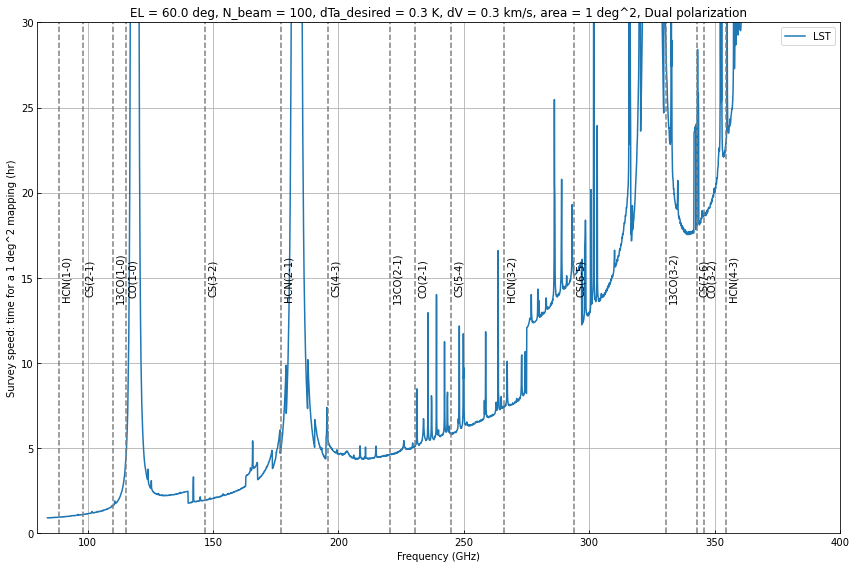

In [34]:
PlotSurveySpeed()

In [35]:
df_lines

,Frequency,HPBW,Tsys,survey_speed
CO(3-2),345.796,4.327491,169.631756,18.858025
13CO(3-2),330.588,4.526457,213.821335,28.409115
C18O(3-2),329.331,4.544326,210.621716,27.456856
CO(2-1),230.538,6.492176,108.263892,5.120296
13CO(2-1),220.399,6.789685,105.205086,4.623192
C18O(2-1),219.560,6.814420,105.106692,4.597799
CO(1-0),115.271,12.978721,142.662293,4.410629
13CO(1-0),110.201,13.579370,88.336470,1.629741
C18O(1-0),109.782,13.628839,87.425911,1.590522
CS(2-1),97.980,15.269862,77.101192,1.104092


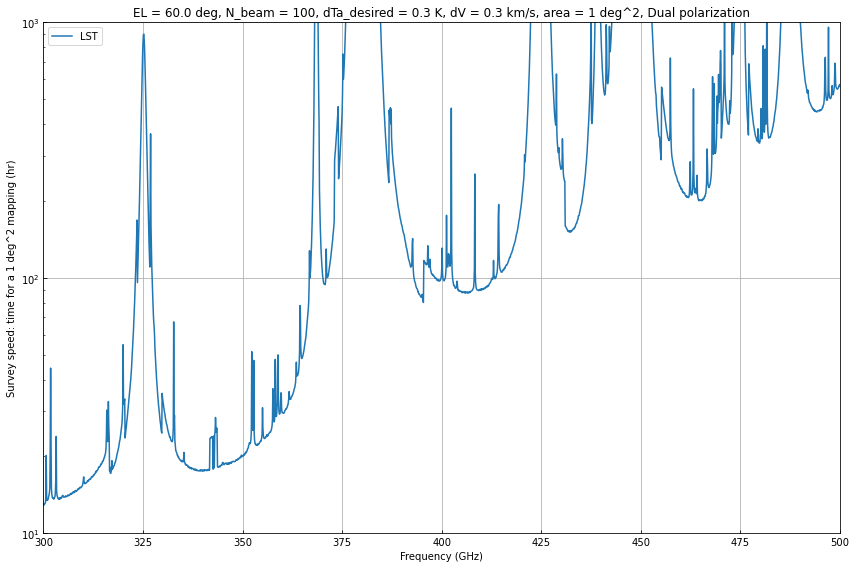

In [36]:
PlotSurveySpeedHigh()